

# Tutorial 4: Train SimSiam on Satellite Images

In this tutorial we will train a SimSiam model in old-school PyTorch style on a
set of satellite images of Italy. We will showcase how the generated embeddings
can be used for exploration and better understanding of the raw data.

You can read up on the model in the paper
[Exploring Simple Siamese Representation Learning](https://arxiv.org/abs/2011.10566).

We will be using a dataset of satellite images from ESAs Sentinel-2 satellite over Italy.
If you're interested, you can get your own data from the [Copernicus Open Acces Hub](https://scihub.copernicus.eu/).
The original images have been cropped into smaller tiles due to their immense size and
the dataset has been balanced based on a simple clustering of the mean RGB color values
to prevent a surplus of images of the sea.

In this tutorial you will learn:

- How to work with the SimSiam model

- How to do self-supervised learning using PyTorch

- How to check whether your embeddings have collapsed


## Imports

Import the Python frameworks we need for this tutorial.



In [1]:
import math

import numpy as np
import torch
import torch.nn as nn
import torchvision

from lightly.data import LightlyDataset
from lightly.loss import NegativeCosineSimilarity
from lightly.models.modules.heads import SimSiamPredictionHead, SimSiamProjectionHead
from lightly.transforms import SimCLRTransform, utils
import torch
import torchvision
from torchvision.datasets import STL10
from lightly.data import LightlyDataset


## Configuration

We set some configuration parameters for our experiment.

The default configuration with a batch size and input resolution of 256
requires 16GB of GPU memory.



In [103]:

# Set parameters
num_workers = 8
batch_size = 256 
seed = 1
epochs = 100
input_size = 96  

# Embedding and prediction parameters
num_ftrs = 512
out_dim = proj_hidden_dim = 512
pred_hidden_dim = 128

Let's set the seed for our experiments and the path to our data



## Setup data augmentations and loaders
Since we're working on satellite images, it makes sense to use horizontal and
vertical flips as well as random rotation transformations. We apply weak color
jitter to learn an invariance of the model with respect to slight changes in
the color of the water.




In [104]:
# Define the augmentations for self-supervised learning
transform = SimCLRTransform(
    input_size=input_size,
    hf_prob=0.5,
    vf_prob=0.5,
    rr_prob=0.5,
    min_scale=0.5,
    cj_prob=0.2,
    cj_bright=0.1,
    cj_contrast=0.1,
    cj_hue=0.1,
    cj_sat=0.1,
)

# Load the STL10 training data
stl10_train = STL10(root='../data', split='unlabeled', download=True, transform=transform)
dataset_train_simsiam = LightlyDataset.from_torch_dataset(stl10_train)

# Dataloader for training
dataloader_train_simsiam = torch.utils.data.DataLoader(
    dataset_train_simsiam,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
)

# Define transformations for testing and embedding
test_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((input_size, input_size)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],  # STL10 dataset mean values
            std=[0.247, 0.243, 0.261],  # STL10 dataset std values
        ),
    ]
)

# Load STL10 test dataset
stl10_test = STL10(root='../data', split='test', download=True, transform=test_transforms)
dataset_test = LightlyDataset.from_torch_dataset(stl10_test)

# Dataloader for testing/embedding
dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

Files already downloaded and verified
Files already downloaded and verified


## Create the SimSiam model

Create a ResNet backbone and remove the classification head



In [91]:
class SimSiam(nn.Module):
    def __init__(self, backbone, num_ftrs, proj_hidden_dim, pred_hidden_dim, out_dim):
        super().__init__()
        self.backbone = backbone
        self.projection_head = SimSiamProjectionHead(num_ftrs, proj_hidden_dim, out_dim)
        self.prediction_head = SimSiamPredictionHead(out_dim, pred_hidden_dim, out_dim)

    def forward(self, x):
        # get representations
        f = self.backbone(x).flatten(start_dim=1)
        # get projections
        z = self.projection_head(f)
        # get predictions
        p = self.prediction_head(z)
        # stop gradient
        z = z.detach()
        return z, p


# we use a pretrained resnet for this tutorial to speed
# up training time but you can also train one from scratch
resnet = torchvision.models.resnet18()
backbone = nn.Sequential(*list(resnet.children())[:-1])
model = SimSiam(backbone, num_ftrs, proj_hidden_dim, pred_hidden_dim, out_dim)

SimSiam uses a symmetric negative cosine similarity loss and does therefore
not require any negative samples. We build a criterion and an optimizer.



In [105]:
# SimSiam uses a symmetric negative cosine similarity loss
criterion = NegativeCosineSimilarity()

# scale the learning rate
lr = 0.01 * batch_size / 256
# use SGD with momentum and weight decay
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

## Train SimSiam

To train the SimSiam model, you can use a classic PyTorch training loop:
For every epoch, iterate over all batches in the training data, extract
the two transforms of every image, pass them through the model, and calculate
the loss. Then, simply update the weights with the optimizer. Don't forget to
reset the gradients!

Since SimSiam doesn't require negative samples, it is a good idea to check
whether the outputs of the model have collapsed into a single direction. For
this we can simply check the standard deviation of the L2 normalized output
vectors. If it is close to one divided by the square root of the output
dimension, everything is fine (you can read
up on this idea [here](https://arxiv.org/abs/2011.10566)).



In [106]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

avg_loss = 0.0
avg_output_std = 0.0
for e in range(epochs):
    for (x0, x1), _, _ in dataloader_train_simsiam:
        # move images to the gpu
        x0 = x0.to(device)
        x1 = x1.to(device)

        # run the model on both transforms of the images
        # we get projections (z0 and z1) and
        # predictions (p0 and p1) as output
        z0, p0 = model(x0)
        z1, p1 = model(x1)

        # apply the symmetric negative cosine similarity
        # and run backpropagation
        loss = 0.5 * (criterion(z0, p1) + criterion(z1, p0))
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        # calculate the per-dimension standard deviation of the outputs
        # we can use this later to check whether the embeddings are collapsing
        output = p0.detach()
        output = torch.nn.functional.normalize(output, dim=1)

        output_std = torch.std(output, 0)
        output_std = output_std.mean()

        # use moving averages to track the loss and standard deviation
        w = 0.9
        avg_loss = w * avg_loss + (1 - w) * loss.item()
        avg_output_std = w * avg_output_std + (1 - w) * output_std.item()

    # the level of collapse is large if the standard deviation of the l2
    # normalized output is much smaller than 1 / sqrt(dim)
    collapse_level = max(0.0, 1 - math.sqrt(out_dim) * avg_output_std)
    # print intermediate results
    print(
        f"[Epoch {e:3d}] "
        f"Loss = {avg_loss:.2f} | "
        f"Collapse Level: {collapse_level:.2f} / 1.00"
    )

[Epoch   0] Loss = -0.85 | Collapse Level: 0.03 / 1.00
[Epoch   1] Loss = -0.84 | Collapse Level: 0.03 / 1.00
[Epoch   2] Loss = -0.87 | Collapse Level: 0.03 / 1.00
[Epoch   3] Loss = -0.86 | Collapse Level: 0.03 / 1.00
[Epoch   4] Loss = -0.87 | Collapse Level: 0.02 / 1.00
[Epoch   5] Loss = -0.86 | Collapse Level: 0.02 / 1.00
[Epoch   6] Loss = -0.86 | Collapse Level: 0.03 / 1.00
[Epoch   7] Loss = -0.87 | Collapse Level: 0.02 / 1.00
[Epoch   8] Loss = -0.87 | Collapse Level: 0.02 / 1.00
[Epoch   9] Loss = -0.87 | Collapse Level: 0.02 / 1.00
[Epoch  10] Loss = -0.88 | Collapse Level: 0.02 / 1.00
[Epoch  11] Loss = -0.87 | Collapse Level: 0.02 / 1.00
[Epoch  12] Loss = -0.88 | Collapse Level: 0.02 / 1.00
[Epoch  13] Loss = -0.86 | Collapse Level: 0.03 / 1.00
[Epoch  14] Loss = -0.87 | Collapse Level: 0.02 / 1.00
[Epoch  15] Loss = -0.88 | Collapse Level: 0.02 / 1.00
[Epoch  16] Loss = -0.88 | Collapse Level: 0.02 / 1.00
[Epoch  17] Loss = -0.87 | Collapse Level: 0.02 / 1.00
[Epoch  18

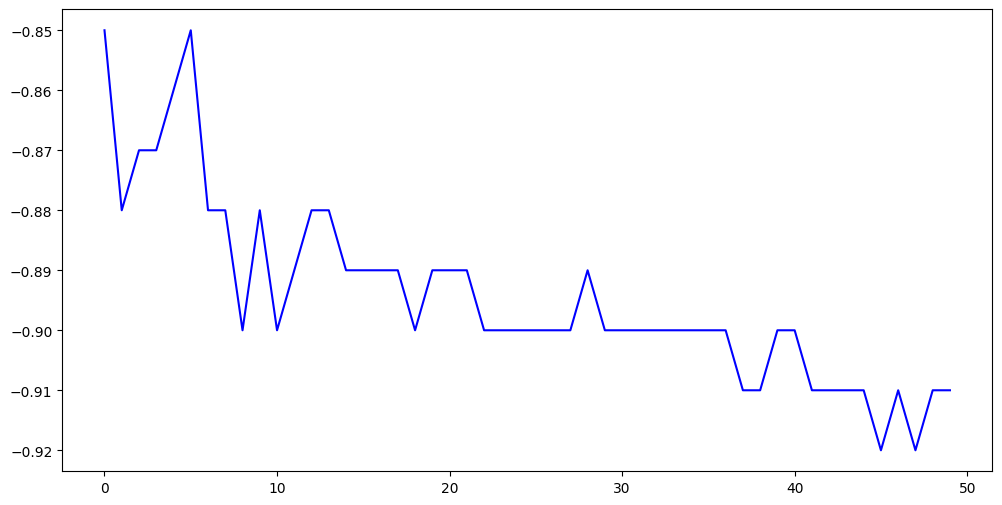

In [94]:
import matplotlib.pyplot as plt

# Data for the first segment of epochs (Epochs 0–42)
epoch1 = list(range(50))
loss1 = [
    -0.85, -0.88, -0.87, -0.87, -0.86, -0.85, -0.88, -0.88, -0.90, -0.88, 
    -0.90, -0.89, -0.88, -0.88, -0.89, -0.89, -0.89, -0.89, -0.90, -0.89,
    -0.89, -0.89, -0.90, -0.90, -0.90, -0.90, -0.90, -0.90, -0.89, -0.90, 
    -0.90, -0.90, -0.90, -0.90, -0.90, -0.90, -0.90, -0.91, -0.91, -0.90,
    -0.90, -0.91, -0.91, -0.91, -0.91, -0.92, -0.91, -0.92, -0.91, -0.91
]
plt.figure(figsize=(12, 6))

# First loss plot (Epochs 0–42)
plt.plot(epoch1, loss1, label="Loss Segment 1 (Epochs 0-42)", color="blue")

In [122]:
new_backbone  = nn.Sequential(*list(model.backbone.children())[:-1])
torch.save(new_backbone.state_dict(), 'backbone_weights_6.pth')

In [127]:
class ClassificationNet(nn.Module):
    def __init__(self, backbone, num_classes):
        super(ClassificationNet, self).__init__()
        self.backbone = backbone
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        features = self.backbone(x)
        pooled_features = nn.AdaptiveAvgPool2d((1, 1))(features)
        pooled_features = pooled_features.view(pooled_features.size(0), -1)
        output = self.classifier(pooled_features)
        return output

classification_model = ClassificationNet(new_backbone, num_classes=10).to(device)

In [116]:
from torchvision import transforms
classification_transform = transforms.Compose([
    # transforms.RandomResizedCrop(96),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  # RGB for classification
])

In [125]:
from torch.utils.data import DataLoader, Dataset
stl10_train = STL10(root='../data', split='train', download=True, transform=classification_transform)
stl10_test = STL10(root='../data', split='test', download=True, transform=classification_transform)

# Fine-tuning: Load training data for classification task
train_loader = DataLoader(stl10_train, batch_size=64, shuffle=True)

# Testing: Load test data for final evaluation
test_loader = DataLoader(stl10_test, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [133]:
# criterion = nn.CrossEntropyLoss()  # multi-class classification
optimizer = torch.optim.Adam(classification_model.parameters(), lr=1e-4)

# Training Loop
num_epochs = 50
for epoch in range(num_epochs):
    classification_model.train()  
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = classification_model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # if (epoch + 1) % 10 == 0:
    #     torch.save(classification_model.state_dict(), f'models/downstream/classification_model_weights_epoch_{epoch+1}.pth')



PATH = 'models/downstream/classification_model_weights_final6.pth'
torch.save(classification_model.state_dict(), PATH)

Epoch [1/50], Loss: 0.0004
Epoch [2/50], Loss: 0.0002
Epoch [3/50], Loss: 0.0002
Epoch [4/50], Loss: 0.0032
Epoch [5/50], Loss: 0.0033
Epoch [6/50], Loss: 0.0005
Epoch [7/50], Loss: 0.0002
Epoch [8/50], Loss: 0.0004
Epoch [9/50], Loss: 0.0001
Epoch [10/50], Loss: 0.0002
Epoch [11/50], Loss: 0.0003
Epoch [12/50], Loss: 0.0002
Epoch [13/50], Loss: 0.0001
Epoch [14/50], Loss: 0.0001
Epoch [15/50], Loss: 0.0001
Epoch [16/50], Loss: 0.0008
Epoch [17/50], Loss: 0.0002
Epoch [18/50], Loss: 0.0002
Epoch [19/50], Loss: 0.0001
Epoch [20/50], Loss: 0.0004
Epoch [21/50], Loss: 0.0004
Epoch [22/50], Loss: 0.0009
Epoch [23/50], Loss: 0.0002
Epoch [24/50], Loss: 0.0002
Epoch [25/50], Loss: 0.0001
Epoch [26/50], Loss: 0.0001
Epoch [27/50], Loss: 0.0002
Epoch [28/50], Loss: 0.0001
Epoch [29/50], Loss: 0.0001
Epoch [30/50], Loss: 0.0003
Epoch [31/50], Loss: 0.0001
Epoch [32/50], Loss: 0.0001
Epoch [33/50], Loss: 0.0030
Epoch [34/50], Loss: 0.0004
Epoch [35/50], Loss: 0.0004
Epoch [36/50], Loss: 0.0002
E

To embed the images in the dataset we simply iterate over the test dataloader
and feed the images to the model backbone. Make sure to disable gradients for
this part.



In [134]:
# Evaluation
classification_model.eval()  # Set model to evaluation mode
correct = 0
top_5_correct = 0
top_3_correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = classification_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        _, predicted_3 = torch.topk(outputs.data, k=3, dim=1)
        correct_3 = predicted_3.eq(labels.unsqueeze(1).expand_as(predicted_3))
        top_3_correct += correct_3.any(dim=1).sum().item()

        _, predicted_5 = torch.topk(outputs.data, k=5, dim=1)
        correct_5 = predicted_5.eq(labels.unsqueeze(1).expand_as(predicted_5))
        top_5_correct += correct_5.any(dim=1).sum().item()



accuracy = 100 * correct / total
top_5 = 100 * top_5_correct / total
top_3 = 100 * top_3_correct / total
print(f'Top-1 Accuracy of the model on the test set: {accuracy:.2f}%')
print(f'Top-5 Accuracy of the model on the test set: {top_5:.2f}%')
print(f'Top-3 Accuracy of the model on the test set: {top_3:.2f}%')

Top-1 Accuracy of the model on the test set: 63.05%
Top-5 Accuracy of the model on the test set: 95.14%
Top-3 Accuracy of the model on the test set: 87.61%


In [86]:
len(next(iter(test_loader)))

2

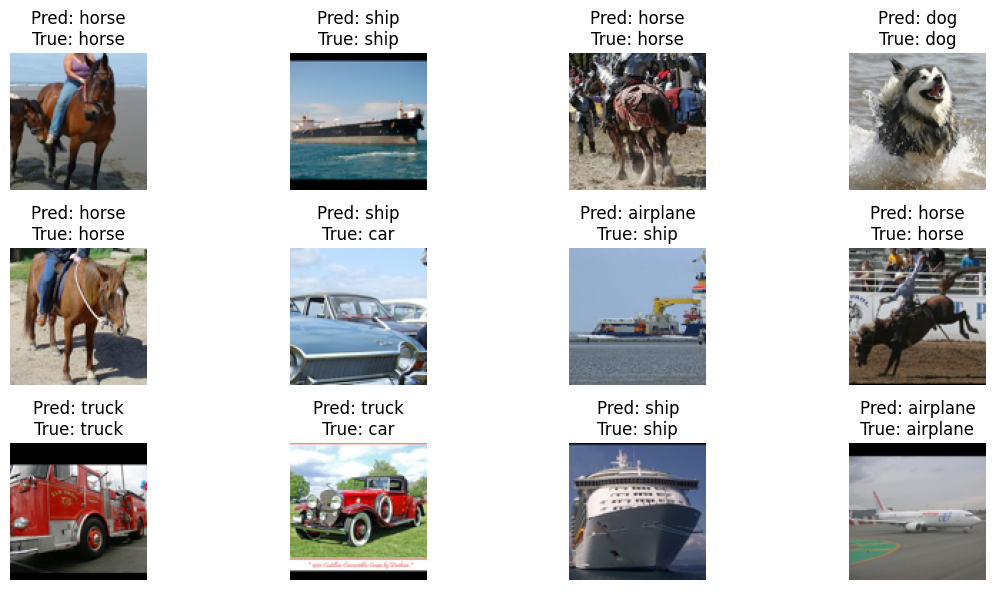

In [137]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# STL-10 class names
class_names = ["airplane", "bird", "car", "cat", "deer", "dog", "horse", "monkey", "ship", "truck"]

# Function to display random test images, predictions, and ground truth labels
def show_random_predictions(model, test_loader, class_names, device):
    model.eval()  # Set model to evaluation mode
    images_shown = 12  # Number of images to display
    fig, axes = plt.subplots(3, 4, figsize=(12, 6))
    axes = axes.flatten()
    
    with torch.no_grad():
        # Get a batch of test images and labels
        all_images, all_labels = next(iter(test_loader))
        indices = torch.randperm(len(all_images))[:images_shown]  # Randomly select indices
        images, labels = all_images[indices].to(device), all_labels[indices].to(device)

        # Run the model to get predictions
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Plot images with predictions and true labels
        for i in range(images_shown):
            image = images[i].cpu().numpy().transpose((1, 2, 0))  # Move channels for plotting
            image = np.clip(image, 0, 1)  # Clip for display purposes
            axes[i].imshow(image)
            axes[i].axis('off')
            axes[i].set_title(f'Pred: {class_names[predicted[i]]}\nTrue: {class_names[labels[i]]}')
    
    plt.tight_layout()
    plt.show()

# Call the function to display random predictions on STL-10 test set
show_random_predictions(classification_model, test_loader, class_names, device)


In [ ]:
embeddings = []
filenames = []

# disable gradients for faster calculations
model.eval()
with torch.no_grad():
    for i, (x, _, fnames) in enumerate(dataloader_test):
        # move the images to the gpu
        x = x.to(device)
        # embed the images with the pre-trained backbone
        y = model.backbone(x).flatten(start_dim=1)
        # store the embeddings and filenames in lists
        embeddings.append(y)
        filenames = filenames + list(fnames)

# concatenate the embeddings and convert to numpy
embeddings = torch.cat(embeddings, dim=0)
embeddings = embeddings.cpu().numpy()

## Scatter Plot and Nearest Neighbors
Now that we have the embeddings, we can visualize the data with a scatter plot.
Further down, we also check out the nearest neighbors of a few example images.

As a first step, we make a few additional imports.



In [ ]:
# for plotting
import os

import matplotlib.offsetbox as osb
import matplotlib.pyplot as plt

# for resizing images to thumbnails
import torchvision.transforms.functional as functional
from matplotlib import rcParams as rcp
from PIL import Image

# for clustering and 2d representations
from sklearn import random_projection

Then, we transform the embeddings using UMAP and rescale them to fit in the
[0, 1] square.




In [ ]:
# for the scatter plot we want to transform the images to a two-dimensional
# vector space using a random Gaussian projection
projection = random_projection.GaussianRandomProjection(n_components=2)
embeddings_2d = projection.fit_transform(embeddings)

# normalize the embeddings to fit in the [0, 1] square
M = np.max(embeddings_2d, axis=0)
m = np.min(embeddings_2d, axis=0)
embeddings_2d = (embeddings_2d - m) / (M - m)

Let's start with a nice scatter plot of our dataset! The helper function
below will create one.



In [ ]:
def get_scatter_plot_with_thumbnails():
    """Creates a scatter plot with image overlays."""
    # initialize empty figure and add subplot
    fig = plt.figure()
    fig.suptitle("Scatter Plot of the Sentinel-2 Dataset")
    ax = fig.add_subplot(1, 1, 1)
    # shuffle images and find out which images to show
    shown_images_idx = []
    shown_images = np.array([[1.0, 1.0]])
    iterator = [i for i in range(embeddings_2d.shape[0])]
    np.random.shuffle(iterator)
    for i in iterator:
        # only show image if it is sufficiently far away from the others
        dist = np.sum((embeddings_2d[i] - shown_images) ** 2, 1)
        if np.min(dist) < 2e-3:
            continue
        shown_images = np.r_[shown_images, [embeddings_2d[i]]]
        shown_images_idx.append(i)

    # plot image overlays
    for idx in shown_images_idx:
        thumbnail_size = int(rcp["figure.figsize"][0] * 2.0)
        path = os.path.join(path_to_data, filenames[idx])
        img = Image.open(path)
        img = functional.resize(img, thumbnail_size)
        img = np.array(img)
        img_box = osb.AnnotationBbox(
            osb.OffsetImage(img, cmap=plt.cm.gray_r),
            embeddings_2d[idx],
            pad=0.2,
        )
        ax.add_artist(img_box)

    # set aspect ratio
    ratio = 1.0 / ax.get_data_ratio()
    ax.set_aspect(ratio, adjustable="box")


# get a scatter plot with thumbnail overlays
get_scatter_plot_with_thumbnails()

Next, we plot example images and their nearest neighbors (calculated from the
embeddings generated above). This is a very simple approach to find more images
of a certain type where a few examples are already available. For example,
when a subset of the data is already labelled and one class of images is clearly
underrepresented, one can easily query more images of this class from the
unlabelled dataset.

Let's get to work! The plots are shown below.



In [ ]:
example_images = [
    "S2B_MSIL1C_20200526T101559_N0209_R065_T31TGE/tile_00154.png",  # water 1
    "S2B_MSIL1C_20200526T101559_N0209_R065_T32SLJ/tile_00527.png",  # water 2
    "S2B_MSIL1C_20200526T101559_N0209_R065_T32TNL/tile_00556.png",  # land
    "S2B_MSIL1C_20200526T101559_N0209_R065_T31SGD/tile_01731.png",  # clouds 1
    "S2B_MSIL1C_20200526T101559_N0209_R065_T32SMG/tile_00238.png",  # clouds 2
]


def get_image_as_np_array(filename: str):
    """Loads the image with filename and returns it as a numpy array."""
    img = Image.open(filename)
    return np.asarray(img)


def get_image_as_np_array_with_frame(filename: str, w: int = 5):
    """Returns an image as a numpy array with a black frame of width w."""
    img = get_image_as_np_array(filename)
    ny, nx, _ = img.shape
    # create an empty image with padding for the frame
    framed_img = np.zeros((w + ny + w, w + nx + w, 3))
    framed_img = framed_img.astype(np.uint8)
    # put the original image in the middle of the new one
    framed_img[w:-w, w:-w] = img
    return framed_img


def plot_nearest_neighbors_3x3(example_image: str, i: int):
    """Plots the example image and its eight nearest neighbors."""
    n_subplots = 9
    # initialize empty figure
    fig = plt.figure()
    fig.suptitle(f"Nearest Neighbor Plot {i + 1}")
    #
    example_idx = filenames.index(example_image)
    # get distances to the cluster center
    distances = embeddings - embeddings[example_idx]
    distances = np.power(distances, 2).sum(-1).squeeze()
    # sort indices by distance to the center
    nearest_neighbors = np.argsort(distances)[:n_subplots]
    # show images
    for plot_offset, plot_idx in enumerate(nearest_neighbors):
        ax = fig.add_subplot(3, 3, plot_offset + 1)
        # get the corresponding filename
        fname = os.path.join(path_to_data, filenames[plot_idx])
        if plot_offset == 0:
            ax.set_title(f"Example Image")
            plt.imshow(get_image_as_np_array_with_frame(fname))
        else:
            plt.imshow(get_image_as_np_array(fname))
        # let's disable the axis
        plt.axis("off")


# show example images for each cluster
for i, example_image in enumerate(example_images):
    plot_nearest_neighbors_3x3(example_image, i)

## Next Steps

Interested in exploring other self-supervised models? Check out our other
tutorials:

- `lightly-moco-tutorial-2`
- `lightly-simclr-tutorial-3`
- `lightly-custom-augmentation-5`
- `lightly-detectron-tutorial-6`


